# Objectives:

In this notebook, 

1. We create a synthetic dataset by 
* selecting few random centeroids
* create n random datapoints around each centeriod
2.  plot the clusters created as a results of this synthetic data
3. Apply kmeans to see if the algorithm can mimic the clusters the way we did!
4. You play abit with hyperparameters and see it for yourself

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

## K-MEANS

### Generating clusters to show how K-Means reproduce them 

#### Generating centers (this is artificial data just for demonstration)

[[0.64492015 0.10529749]
 [0.76246598 0.09649613]
 [0.48400946 0.26098889]
 [0.11907973 0.40552328]
 [0.62815526 0.88280828]
 [0.56151585 0.77701509]
 [0.81926192 0.80905864]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  # Remove the CWD from sys.path while we load stuff.


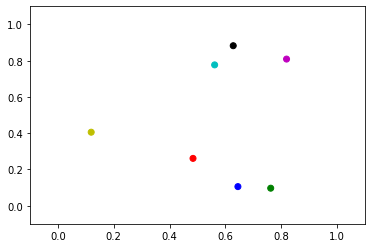

In [31]:
trueK = 7 # Desired number of clusters to generate
colors = 'bgrykcm' # the letters are defining colors for each K. For instance, b is blue and g is gray. 

dim = 2 # dimension of feature space
n = 250 # points per cluster

trueCentroids = np.random.rand(trueK,dim) # generating centroids at random
print(trueCentroids)
if dim==2:
    plt.scatter(trueCentroids[:,0],trueCentroids[:,1], color=colors)
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.show()

#### Generating synthetic datapoints around each center
#### Using multivariate normal distribution with a randomly generated covariance matrix

In [32]:
sigma_xx = 0.001 # factor for variance - decides on how far can each new point be from the mean  (try 0.01)
sigma_xy = 0.001 # factor for covariance - decides on how dar x and y can fall apart try(0.001)
XasList = [] # storing the points around each center, as a list of arrays (one array per center)
X = trueCentroids # The actual centroids, to which the generated points will be added

# loop through the centroids
for c in trueCentroids:
    # data generated for each centroid:
    X_c = np.random.multivariate_normal(c,np.array([[sigma_xx*np.random.rand(),  sigma_xy*(2*np.random.rand()-1)], 
                                                    [sigma_xy*(2*np.random.rand()-1), sigma_xx*np.random.rand()]]), n) 
    #print(X_c)
    XasList.append(X_c) # list of arrays
    X = np.append(X,X_c, axis=0) # single array

np.random.shuffle(X) # shuffle the array

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


#### Computing clusters

#Plot the points

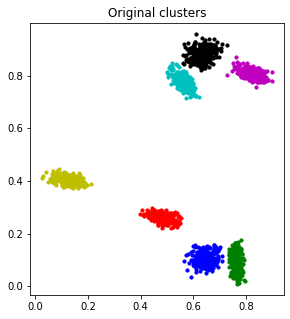

In [33]:
plt.figure(figsize=(10,5))
#show the artificially generated data
plt.subplot(1,2,1)
for J in range(trueK):
    X_c = XasList[J]
    plt.scatter(X_c[:, 0], X_c[:, 1], c=colors[J], s=10) 
    plt.title("Original clusters")
    plt.xlim(-0.2,1.2)
    plt.ylim(-0.2,1.2)
    plt.axis('equal')

In [34]:
#Write a code to import kmean library from SKLearn
from sklearn.cluster import KMeans

#fit the KMeans model on X
#n_cluster should be equal to trueK
kmeans = KMeans(n_clusters=trueK, random_state=0).fit(X)  #what's n_clusters and why? fit what?


#### Visualizing true vs computed clusters

Note that the colors do not match because the labels chosen by the clustering algorithm do not need to match the artificial ones we started with.

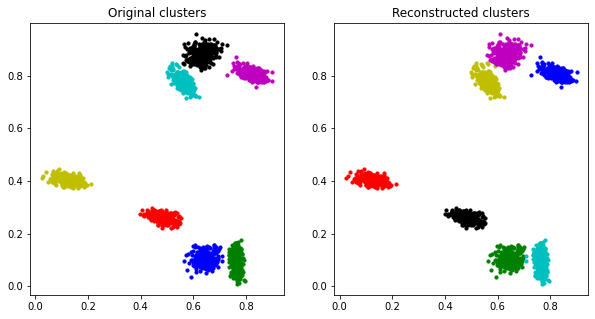

In [35]:
plt.figure(figsize=(10,5))
#plot the data points with colours differentiating the clusters they originally should belong to
plt.subplot(1,2,1)
for J in range(trueK):
    X_c = XasList[J]
    plt.scatter(X_c[:, 0], X_c[:, 1], c=colors[J], s=10) 
    plt.title("Original clusters")
    plt.xlim(-0.2,1.2)
    plt.ylim(-0.2,1.2)
    plt.axis('equal')

#plot the data points with cluster colours showing how the clustering algorithm resolved them as different clusters
plt.subplot(1,2,2)    
for J in range(trueK):
    X_J = X[kmeans.labels_==J]
    plt.title("Reconstructed clusters")
    plt.scatter(X_J[:, 0], X_J[:, 1], c=colors[J], s=10)
    plt.xlim(-0.2,1.2)
    plt.ylim(-0.2,1.2)
    plt.axis('equal')
plt.show()    

### Measuring Clustering Performance

#### A function that measures the _cost_ of a specific clustering is called _inertia_

#### Inertia is computed as the sum of the square distances between each point and the center of the cluster to which the point is assigned.

Inertia is one of the attributes of the learned model (below is redefined as getInertia, although not used)

A complementary measure of performance is to look at what below is called inertia2, which is the sum of the squares distances between each point and the 2nd closest cluster

A nice clustering solution should have small inertia, and large inertia2: that means:

    - points are close to the center of their cluster
    - points are far from the center of the other clusters (since they are far to the closest center of the other clusters)

In [36]:
def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

In [37]:
def getInertia2(X,kmeans):
    ''' This function is analogous to getInertia, but with respect to the 2nd closest center, rather than closest one'''
    inertia2 = 0
    for J in range(len(X)):
        L = min(1,len(kmeans.cluster_centers_)-1) # this is just for the case where there is only 1 cluster at all
        dist_to_center = sorted([np.linalg.norm(X[J] - z)**2 for z in kmeans.cluster_centers_])[L]
        inertia2 = inertia2 + dist_to_center
    return inertia2   

In addition to _inertia_ we compute the ration between _interia_ and _inertia2_. 

Another performance measure is called _silhouette_:

The silhouette $s(x)$ for a point $x$ is defined as:

$$ s(x) = \frac{b(x)-a(x)}{\max\{a(x),b(x)\}} $$

where 

- $a(x)$ is the average distance between $x$ and the points in the cluster $x$ belongs

- $b(x)$ is the lowest average distance between $x$ and the points the clusters $x$ does not belong to

$s(x)$ is a quantity in $[-1,1]$. The silhouette score is the average silhouette score among all the points: $\frac{1}{|X|} \sum_x s(x)$

**- The bigger is the silhouette score the better. Large silhouette indicates that points in the cluster are very similar and points in different clusters are dissimilar.**

### Computing 3 performance measures for a range of values of $k$

In [38]:
inertias_1 = [] #empty list to store inertia 1
inertias_2 = [] #empty list to store inertia 2
silhouette_avgs = [] #empty list to store silhouette scores
max_K = trueK  #loop through this many K values and store the performance metrics for each K
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)  
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(X,kmeans)]
    print(kmeans.inertia_, getInertia2(X,kmeans) ) #print inertia 1 and 2 for the current K

    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]
        print("silhouette_score: ",silhouette_score(X, kmeans.labels_)) #print silhouette score for the current K

258.0487314097503 258.0487314097503
87.79910714636534 782.9850728885195
silhouette_score:  0.6507744511171117
27.21661048986707 661.1504710672356
silhouette_score:  0.752154927879011
14.792707266542271 372.56688325443844
silhouette_score:  0.7625032265267084
6.083142243488564 139.09843770975883
silhouette_score:  0.7308958778395913
4.006394554244984 116.67247010635005
silhouette_score:  0.7396253366926109
2.2496677762752357 78.73031316032464
silhouette_score:  0.7230364928463633


### Plotting performances

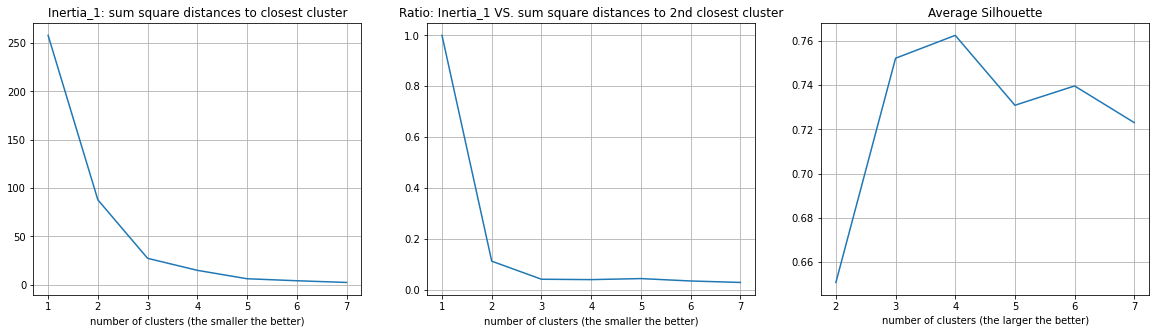

In [39]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters (the smaller the better)')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters (the smaller the better)')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters (the larger the better)')
plt.grid()

plt.show()

### Analyzing the plots to determine the optimal value of $k$

In this case the data was created to have $k$ clusters, but in practice this is of course unknown, and one of the user's tasks is to determine the appropriate value of $k$.

In the first case (looking at inertias) what we are looking for is an "elbow" in the graph. In this case, it is located around $k=7$. Notice that we do not choose the value of $k$ with the smallest value since the inertia keeps decreasing as $k$ increase. This is by construction of the quantity _inertia_. 

When looking at the ration between inertia_1 and inertia_2, one looks for a minimum value, which in this case corresponds with $k=7$ as well.

The silhouette gives higher values for best clusterings, so what we look for is a maximum, which happens again at $k=7$.

With real data (non-synthetic) it is trickier to find the best value of $k$ since it is not so obvious as in the example above. Often there are a few options that seem reasonable. Having these 3 differents approaches to determine a convenient value of $k$ should help narrowing down the options for $k$.

# Your turn!
Review the flow of coding for yourself. Do not focus on how we created synthetic data, rather focus on "when the data is ready, what should be done" and try to follow that process so you learn what you should do next time you want to build model.

Next, go to kmeans section above and modify the code  with below parameters and check the outcome. 

1. trueK = 3 # Desired number of clusters
2. colors = 'bgr'
3. n = 10 and also try with n = 60
4. Share your Inertia and inertia2 results with each other. 
